# Simple Meshing Workflow

This is a simple workflow for generating 1D and 2D meshes.  Note this workflow can do simple 3D meshes as well, especially for simple topography like hexahedral meshes that track a DEM or similar.

Often, even in very simple simulations, we use variable vertical resolution (dz).  For many processes (infiltration vs runoff generation, thermal processes, vegetation) much of the dynamics happens in the very near surface soil (within the top centimeters to meters, or in the critical zone).  That said, groundwater depths or the annual thermal signal can propogate to many meters below the surface.  To resolve the near surface dynamics without using so many cells that the simulation is unnecessarily expensive to run, we often use small dz (\~10cm or less) at the surface and much coarser (\~1-5 m) at depth.

This workflow, and most ATS workflows, make **terrain following, extruded** meshes.  These meshes can be unstructured in map-view, but follow the same vertical spacing everywhere.  This is not required for ATS, but is the most commonly used type of mesh.

Note that an unstructured mesh is completely specified by:
* nodal coordinates
* topology (faces as collections of nodes, cells as collections of faces)
* labeled sets (collections of nodes, faces, or cells)

This workflow uses the "meshing_ats" tool provided with the ATS repository.


## Note on mesh dimensionality

All meshes have two dimensions -- the "spatial" dimension (the dimension of the coordinates of the nodes) and the "manifold" dimension (the dimension of a single cell).  ATS uses:

* 3 space, 3 manifold: standard volumetric mesh in 3D
* 3 space, 2 manifold: the surface of the Earth
* 2 space, 2 manifold: a flattened surface mesh whose z-coordinate has been removed
* 1 space, 1 manifold: very few processes use a true 1D mesh

## Note on labels

Labels must be unique.  Therefore we use the following conventions to make life simpler across all ATS meshes.  This is not _required_, but is strongly encouraged.

* 1 : the bottom boundary faces of the domain
* 2 : the top (surface) boundary faces of the domain
* 3 : all other boundary faces (side boundaries)
* 4-9 : reserved for user-provided sets, e.g. outlets, observation points, etc.
* 10-99 : Land Cover side sets, typically NLCD indices are used directly
* 100 : geologic layer material IDs, e.g. rock types
* 999 : reserved for bedrock
* 1000-9999 : soil layer material IDs, e.g. soil types
* 10000+ : user-defined, no limitations


## Note on format

We write these meshes to ExodusII files.  ExodusII can handle two types of meshes -- "fixed type" meshes, which contain only elements of a given type (e.g. tetrahedrons, hexahedrons, triangular prisms, etc) or "polyhedral meshes."  In the former, faces are not stored -- instead, each cell is a list of nodes ordered in a particular way.  In the latter, faces are stored explicitly as a list of  nodes, and cells are stored as a list of faces.  ATS meshing workflows tend to write the latter, because it is actually simpler, and typed meshes can be stored as polyhedral meshes.

Vis tools like VisIt and Paraview tend to do better with fixed type meshes, however.  If you write a fixed type mesh in polyhedral form, MSTK's `meshconvert` utility can be used to detect and change the type automatically.  This is built and installed with ATS:

    $AMANZI_TPLS_DIR/bin/meshconvert transect.exo transect_fixed_format.exo



In [1]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt


## Column Mesh

Columns are useful for getting started, comparing to lab experiments, or for large, flat horizontal extents, where all of the dynamics are assumed to be 1D.

Note that we use the phrase: "column of cells" to make clear that this is still a 3D volume mesh, but has only 1 cell when projected into map-view.

In this exercise we will make a column of cells of three types -- organic-rich layer, mineral soil layer, and bedrock.  The organic-rich layer will be the top 25cm, the mineral soil from 25cm to 2m, and the bedrock from 2m to 40m depth.


In [2]:
# Make a surface mesh that is a 1m x 1m box in map-view.
#
# note that 2D here refers to the "manifold" dimension -- nodes are 3D, but this 
# describes a surface consisting of once cell.
m2c = meshing_ats.Mesh2D.from_Column(0.,0.,0., width=1)
print(f'# of cells: {m2c.num_cells()}')

# of cells: 1


In [3]:
# Prepare layer extrusion data
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical units to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the total thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.
        

In [4]:
# first, prescribe a single layer, 5 cells @ 5cm = 25 cm of organic-rich soil
layer_types.append('constant')
layer_data.append(0.25)
layer_ncells.append(5)
layer_mat_ids.append(1001) # organic-rich soil ID number
current_depth = 0.25


In [5]:
# next, we want a mineral soil layer ranging from 0.25m to 2m deep
# -- add another layer of 5 cells @ 5cm = 25 more cm of mineral soil
layer_types.append('constant')
layer_data.append(0.25)
layer_ncells.append(5)
layer_mat_ids.append(1002) # mineral-soil ID number
current_depth += 0.25


In [6]:
# -- next, we start to grow dz by factors of 2, til we hit 2m
dz = .05
i = 0
while current_depth < 2:
    dz *= 2
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1002) # mineral soil
    current_depth += dz
    i += 1
    
# -- where are we at?
print(f"After the mineral layer, dz = {dz}, current_depth={current_depth}")

# By careful choice of the number of cells and dz, we are now at 2m.
# 
# Now add in a bunch of 2m cells to reach 40 m, of equal dz that is ~2m.
layer_types.append("constant")
layer_data.append(38)
layer_ncells.append(38//2) # note, // is integer division
layer_mat_ids.append(999) # bedrock material ID
current_depth += 38


After the mineral layer, dz = 0.8, current_depth=2.0


In [7]:
# print a summary of the final layering
meshing_ats.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)


Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	| 1001 	|   0.050000 	|   0.000000
 00 	| 01 	| 1001 	|   0.050000 	|   0.050000
 00 	| 02 	| 1001 	|   0.050000 	|   0.100000
 00 	| 03 	| 1001 	|   0.050000 	|   0.150000
 00 	| 04 	| 1001 	|   0.050000 	|   0.200000
 01 	| 05 	| 1002 	|   0.050000 	|   0.250000
 01 	| 06 	| 1002 	|   0.050000 	|   0.300000
 01 	| 07 	| 1002 	|   0.050000 	|   0.350000
 01 	| 08 	| 1002 	|   0.050000 	|   0.400000
 01 	| 09 	| 1002 	|   0.050000 	|   0.450000
 02 	| 10 	| 1002 	|   0.100000 	|   0.500000
 03 	| 11 	| 1002 	|   0.200000 	|   0.600000
 04 	| 12 	| 1002 	|   0.400000 	|   0.800000
 05 	| 13 	| 1002 	|   0.800000 	|   1.200000
 06 	| 14 	|  999 	|   2.000000 	|   2.000000
 06 	| 15 	|  999 	|   2.000000 	|   4.000000
 06 	| 16 	|  999 	|   2.000000 	|   6.000000
 06 	| 17 	|  999 	|   2.000000 	|   8.000000
 0

In [8]:
# Turn this into a 3D mesh (column of cells), and save it to disk
m3c = meshing_ats.Mesh3D.extruded_Mesh2D(m2c, layer_types, layer_data, layer_ncells, layer_mat_ids)
if os.path.exists('column.exo'):
    os.remove('column.exo')
m3c.write_exodus('column.exo')



You are using exodus.py v 1.20.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: column.exo
Closing exodus file: column.exo


## Transect Mesh

As a next step, make a transect mesh.  This mesh is also a 3D volumetric mesh, but is conceptually a 2D mesh.  Think of this as a cross-section of a hillslope.  

# of x and z coordinates: 101, 101
# of cells: 100


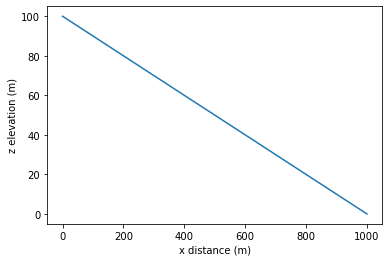

In [9]:
# Specify the top surface, given by z(x).
#
# 1 km long hillslope, 10% slope, 100 cells (or 101 nodes) in x.
x = np.linspace(0,1000,101)
z = 100 - 0.1*x
print(f'# of x and z coordinates: {len(x)}, {len(z)}')

# plot the surface topography
plt.plot(x,z); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')

# make the (manifold) 2D mesh.
m2 = meshing_ats.Mesh2D.from_Transect(x,z)
print(f'# of cells: {m2.num_cells()}')

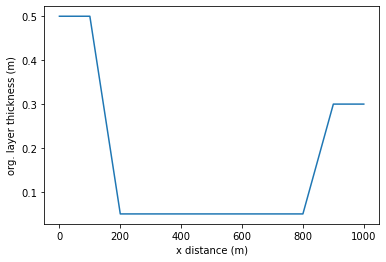

In [10]:
# In this mesh, we vary the organic layer thickness across the hillslope.
#
# Changing organic layer thickness 
def organic_thickness(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    if x < 100:
        thickness = 0.5
    elif ((100 <= x) and (x <= 200)):
        thickness = -0.0045*x + 0.95
    elif ((200 < x) and (x < 800)):
        thickness = 0.05
    elif ((800 <= x) and (x <= 900)):
        thickness = 0.0025*x - 1.95
    else:
        thickness = 0.3
    return thickness

org_layer_thickness = np.array([organic_thickness(xx) for xx in m2.coords[:,0]])
plt.plot(x, org_layer_thickness[0:101]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');


In [11]:
# geometry of the transect extrusion
transect_layer_types = []
transect_layer_data = []
transect_layer_ncells = []

depth = []  # bookkeeping for material IDs
current_depth = 0

# We use the same dz as the above column, but because the material ID will change
# at a given depth in x, we spell it out with 1 cell per transect.
#
# 10 cells @ 5cm
dz = .05
depth.append(current_depth)
for i in range(10):
    transect_layer_types.append('constant')
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)
    
# grow dz by factors of 2, til we hit 2m
i = 0
while current_depth < 2:
    dz *= 2
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)

# 2m cells to 40m
dz = 2
while current_depth < 40:
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)


In [12]:
# calculate the cell centroid depth
depth = np.array(depth)
transect_layer_depth = (depth[0:-1] + depth[1:])/2

# allocate 2D matrix for material id, (# surface cells, # layers)
n_layers = len(transect_layer_data)
transect_layer_mat_ids=np.zeros((n_layers, m2.num_cells()), 'i')
for j in range(m2.num_cells()):
    for i in range(n_layers):
        if (transect_layer_depth[i] < org_layer_thickness[j]):
            transect_layer_mat_ids[i,j] = 1001
        elif transect_layer_depth[i] < 2:
            transect_layer_mat_ids[i,j] = 1002
        else:
            transect_layer_mat_ids[i,j] = 999


In [13]:
# print out the layer information for the first column of cells
meshing_ats.summarize_extrusion(transect_layer_types, transect_layer_data, 
                                transect_layer_ncells, transect_layer_mat_ids, 0)


Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	| 1001 	|   0.050000 	|   0.000000
 01 	| 01 	| 1001 	|   0.050000 	|   0.050000
 02 	| 02 	| 1001 	|   0.050000 	|   0.100000
 03 	| 03 	| 1001 	|   0.050000 	|   0.150000
 04 	| 04 	| 1001 	|   0.050000 	|   0.200000
 05 	| 05 	| 1001 	|   0.050000 	|   0.250000
 06 	| 06 	| 1001 	|   0.050000 	|   0.300000
 07 	| 07 	| 1001 	|   0.050000 	|   0.350000
 08 	| 08 	| 1001 	|   0.050000 	|   0.400000
 09 	| 09 	| 1001 	|   0.050000 	|   0.450000
 10 	| 10 	| 1002 	|   0.100000 	|   0.500000
 11 	| 11 	| 1002 	|   0.200000 	|   0.600000
 12 	| 12 	| 1002 	|   0.400000 	|   0.800000
 13 	| 13 	| 1002 	|   0.800000 	|   1.200000
 14 	| 14 	|  999 	|   2.000000 	|   2.000000
 15 	| 15 	|  999 	|   2.000000 	|   4.000000
 16 	| 16 	|  999 	|   2.000000 	|   6.000000
 17 	| 17 	|  999 	|   2.000000 	|   8.000000
 1

In [14]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, transect_layer_types,transect_layer_data, 
                                        transect_layer_ncells, transect_layer_mat_ids)
if os.path.exists('transect.exo'):
    os.remove('transect.exo')
m3.write_exodus('transect.exo')

Opening exodus file: transect.exo
Closing exodus file: transect.exo


In [15]:
# Now convert the file from "polyhedral" to "fixed format" and open it in VisIt or Paraview.
os.system("$AMANZI_TPLS_DIR/bin/meshconvert transect.exo transect_fixed_format.exo")



App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0

![transect1.pnt](./transect1.png)

![transect2.png](./transect2.png)